# Selección de vectorizador

In [1]:
from copy import deepcopy
import math
import os
import re
import sys

import joblib
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    make_scorer, f1_score, precision_score, recall_score, roc_auc_score
)
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

from config import DATA_PATH, MODELS_PATH, VISUALIZATIONS_PATH
from notebooks.src.vectorizers import *

In [2]:
os.makedirs(MODELS_PATH, exist_ok=True)

In [3]:
data_path = os.path.join(DATA_PATH, "session_speech.csv")
data = pd.read_csv(data_path, converters={"speech_lemma_pos":eval})
data.columns

Index(['name', 'vote', 'senator', 'province', 'party', 'party_family',
       'speaker', 'speech', 'speech_preprocessed', 'speech_lemmas',
       'speech_pos', 'speech_lemma_pos', 'speech_preprocessed_count',
       'speech_preprocessed_count_unique', 'speech_lemmas_count',
       'speech_lemmas_count_unique', 'speech_pos_count',
       'speech_pos_count_unique', 'speech_lemma_pos_count_unique'],
      dtype='object')

In [4]:
data = (
    data[(data.speech.notna()) & (~data.vote.isin(["abstención", "ausente"]))]
    .reset_index(drop=True)
    .assign(
        speech_lemma_pos=lambda x: x.speech_lemma_pos.apply(
            lambda z: " ".join(["_".join(i) for i in z])
        )
    )
)
data[["speech_lemma_pos", "vote"]]

,speech_lemma_pos,vote
0,hacer_VERB año_NOUN tener_VERB una_DET sesión_...,positivo
1,gracia_NOUN señor_NOUN presidente_NOUN hoy_ADV...,negativo
2,como_SCONJ ir_VERB a_ADP pedir_VERB la_DET ins...,negativo
3,gracia_NOUN presidenta_NOUN nuevamente_ADV yo_...,negativo
4,gracia_NOUN señora_NOUN presidenta_NOUN realme...,negativo
...,...,...
194,gracia_NOUN presidenta_NOUN antes_ADV de_ADP c...,positivo
195,mucha_ADJ gracia_NOUN señora_NOUN presidenta_N...,positivo
196,ya_ADV presidenta_NOUN,positivo
197,en_ADP cuanto_ADJ al_ADP artículo_NOUN propone...,positivo


In [5]:
data.vote.value_counts(normalize=True)

vote
positivo    0.557789
negativo    0.442211
Name: proportion, dtype: float64

## Separación en _train_ y _test_

In [6]:
X_train_index, X_test_index = train_test_split(
    data.index,
    test_size=.2,
    random_state=6300,
    shuffle=True,
    stratify=data.vote
)

In [7]:
for index, name in zip([X_train_index, X_test_index], ["entrenamiento", "testeo"]):
    print(f"** Cantidad de datos en conjunto de {name}: {index.shape[0]}")
    print("** Distribución de la variable target:")
    print(f"{data.loc[index, 'vote'].value_counts(normalize=True).to_frame()}", end="\n\n")

** Cantidad de datos en conjunto de entrenamiento: 159
** Distribución de la variable target:
          proportion
vote                
positivo    0.559748
negativo    0.440252

** Cantidad de datos en conjunto de testeo: 40
** Distribución de la variable target:
          proportion
vote                
positivo        0.55
negativo        0.45



In [8]:
INDEX = os.path.join(MODELS_PATH, "index")
os.makedirs(INDEX, exist_ok=True)

for file in ["X_train_index", "X_test_index"]:
    dataset = eval(file)
    dataset.to_series().to_csv(os.path.join(INDEX, f"{file}.csv"), header=None, index=False)

## _Encoding_ de variables

### Variable _target_

In [9]:
le = LabelEncoder()

data["target"] = le.fit_transform(data.vote)

In [10]:
for value in data.vote.unique():
    print(f"Categoría {value} ---> {le.transform([value])[0]}")

Categoría positivo ---> 1
Categoría negativo ---> 0


In [11]:
le_path = os.path.join(MODELS_PATH, "labelencoder.pkl")
_ = joblib.dump(le, le_path)

## Selección de vectorizador

In [12]:
vectorizers = [
    {"name": "Frecuencias absolutas","class": CustomFrequenciesVectorizer, "kwargs": {}},
    {"name": "Proporciones","class": CustomProportionsVectorizer, "kwargs": {}},
    {"name": "Proporciones","class": CustomProportionsVectorizer, "kwargs": {"stop_words": "nltk"}},
    {"name": "Proporciones","class": CustomProportionsVectorizer, "kwargs": {"stop_words": "zipf"}},
    {"name": "Ratio de odds","class": CustomOddsRatioVectorizer, "kwargs": {}},
    {"name": "Ratio de log odds","class": CustomLogOddsRatioVectorizer, "kwargs": {}},
    {"name": "Ratio de log odds","class": CustomLogOddsRatioVectorizer, "kwargs": {"smooth": .5}},
    {"name": "Word scores","class": CustomWordScoresVectorizer, "kwargs": {}},
    {"name": "TF-IDF","class": CustomTfidfVectorizer, "kwargs": {}},
    {"name": "TF-IDF","class": CustomTfidfVectorizer, "kwargs": {"log_idf": True}},
]

In [13]:
FEATURES = os.path.join(MODELS_PATH, "features_selection")
os.makedirs(FEATURES, exist_ok=True)

In [14]:
SEED = 6300

X_trainset, y_trainset = (
    data.loc[X_train_index, "speech_lemma_pos"], data.loc[X_train_index, "target"]
)
cv_method = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
scoring_method = {
    "accuracy": "accuracy",
    "f1": "f1",
    "f1_weighted": make_scorer(f1_score, average="weighted"),
    "f1_macro": make_scorer(f1_score, average="macro"),
    "precision": make_scorer(precision_score),
    "precision_weighted": make_scorer(precision_score, average="weighted"),
    "precision_macro": make_scorer(precision_score, average="macro"),
    "recall": make_scorer(recall_score),
    "recall_weighted": make_scorer(recall_score, average="weighted"),
    "recall_macro": make_scorer(recall_score, average="macro"),
    "roc_auc_weighted": make_scorer(roc_auc_score, average="weighted"),
    "roc_auc_macro": make_scorer(roc_auc_score, average="macro"),
}

cv_results_to_compare = pd.DataFrame()
for vectorizer in vectorizers:
    kwargs = deepcopy(vectorizer.get("kwargs"))
    stop_words = kwargs.pop("stop_words", None)
    if stop_words == "nltk":
        kwargs["stop_words"] = stopwords.words("spanish")
    elif stop_words == "zipf":
        kwargs["custom_stop_words"] = "zipf"
    pipeline = Pipeline([
        (
            "vectorizer",
            vectorizer["class"](
                positive_values=1, dimension=300, **kwargs
            )
        ),
        (
            "clf",
            LogisticRegression(random_state=SEED)
        )
    ])
    print(f"-- Running cross_validate for {pipeline.steps[0][1]}")
    cv_results = cross_validate(
        pipeline, X_trainset, y_trainset, cv=cv_method, 
        n_jobs=-1, return_train_score=True, scoring=scoring_method
    )
    cv_results_df = (
        pd.DataFrame(cv_results)
        .assign(split=lambda x: x.index+1)
    )
    cv_results_df["vectorizer"] = vectorizer["name"]
    cv_results_df["kwargs"] = pd.Series([vectorizer["kwargs"]]*len(cv_results_df))
    cv_results_to_compare = pd.concat(
        [cv_results_to_compare, cv_results_df], ignore_index=True
    )
file_path = os.path.join(FEATURES, "features_selection.csv")
cv_results_to_compare.to_csv(file_path, index=False)

-- Running cross_validate for CustomFrequenciesVectorizer(positive_values=1)


/home/macarena/.pyenv/versions/3.11.4/envs/eddc-tp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/macarena/.pyenv/versions/3.11.4/envs/eddc-tp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

-- Running cross_validate for CustomProportionsVectorizer(positive_values=1)


/home/macarena/.pyenv/versions/3.11.4/envs/eddc-tp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/macarena/.pyenv/versions/3.11.4/envs/eddc-tp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

-- Running cross_validate for CustomProportionsVectorizer(positive_values=1,
                            stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a',
                                        'los', 'del', 'se', 'las', 'por', 'un',
                                        'para', 'con', 'no', 'una', 'su', 'al',
                                        'lo', 'como', 'más', 'pero', 'sus',
                                        'le', 'ya', 'o', 'este', 'sí', 'porque', ...])


/home/macarena/.pyenv/versions/3.11.4/envs/eddc-tp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/macarena/.pyenv/versions/3.11.4/envs/eddc-tp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

-- Running cross_validate for CustomProportionsVectorizer(custom_stop_words='zipf', positive_values=1)
-- Running cross_validate for CustomOddsRatioVectorizer(positive_values=1)
-- Running cross_validate for CustomLogOddsRatioVectorizer(positive_values=1)


/home/macarena/.pyenv/versions/3.11.4/envs/eddc-tp/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/macarena/.pyenv/versions/3.11.4/envs/eddc-tp/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/macarena/.pyenv/versions/3.11.4/envs/eddc-tp/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/macarena/.pyenv/versions/3.11.4/envs/eddc-tp/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/macarena/.pyenv/versions/3.11.4/envs/eddc-tp/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encount

-- Running cross_validate for CustomLogOddsRatioVectorizer(positive_values=1, smooth=0.5)
-- Running cross_validate for CustomWordScoresVectorizer(positive_values=1)


/home/macarena/.pyenv/versions/3.11.4/envs/eddc-tp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/macarena/.pyenv/versions/3.11.4/envs/eddc-tp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

-- Running cross_validate for CustomTfidfVectorizer(positive_values=1)
-- Running cross_validate for CustomTfidfVectorizer(log_idf=True, positive_values=1)


/home/macarena/.pyenv/versions/3.11.4/envs/eddc-tp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/macarena/.pyenv/versions/3.11.4/envs/eddc-tp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [15]:
FEATURES = os.path.join(MODELS_PATH, "features_selection")
file_path = os.path.join(FEATURES, "features_selection.csv")

cv_results_to_compare = pd.read_csv(file_path, converters={"kwargs": eval})
cv_results_to_compare.head()

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_f1_weighted,train_f1_weighted,test_f1_macro,train_f1_macro,...,train_recall_weighted,test_recall_macro,train_recall_macro,test_roc_auc_weighted,train_roc_auc_weighted,test_roc_auc_macro,train_roc_auc_macro,split,vectorizer,kwargs
0,0.140160,0.026083,0.656250,0.952756,0.666667,0.957143,0.657258,0.952833,0.655914,0.952256,...,0.952756,0.662698,0.953974,0.662698,0.953974,0.662698,0.953974,1,Frecuencias absolutas,{}
1,0.133169,0.030806,0.562500,0.842520,0.562500,0.850746,0.562500,0.843068,0.562500,0.842040,...,0.842520,0.571429,0.847837,0.571429,0.847837,0.571429,0.847837,2,Frecuencias absolutas,{}
2,0.125701,0.033191,0.687500,0.905512,0.750000,0.917808,0.677083,0.905056,0.666667,0.903349,...,0.905512,0.666667,0.900402,0.666667,0.900402,0.666667,0.900402,3,Frecuencias absolutas,{}
3,0.136556,0.027672,0.593750,0.921260,0.606061,0.927536,0.594941,0.921476,0.593353,0.920665,...,0.921260,0.599206,0.923919,0.599206,0.923919,0.599206,0.923919,4,Frecuencias absolutas,{}
4,0.125015,0.032995,0.548387,0.906250,0.588235,0.918919,0.548387,0.905781,0.544118,0.903904,...,0.906250,0.544118,0.900794,0.544118,0.900794,0.544118,0.900794,5,Frecuencias absolutas,{}


In [16]:
cv_results_to_compare = (
    cv_results_to_compare
    .assign(
        kwargs_=lambda x: x.kwargs.apply(
            lambda z: ", ".join([f"{k}={v}" for k, v in z.items()])
        ),
        title=lambda x: x.apply(
            lambda z: f"{z.vectorizer} ({z.kwargs_})" if z.kwargs else z.vectorizer,
            axis=1)
        )
)

In [17]:
print((
    cv_results_to_compare
    .groupby("title")["fit_time"]
    .agg(
        media=np.mean,
        mediana=np.median,
        desvío=np.std,
        max=np.max
    )
    .applymap(lambda x: round(x,3))
    .style
    .highlight_min(color="blue")
    .highlight_max(color="red")
    .to_latex()
))

\begin{tabular}{lrrrr}
 & media & mediana & desvío & max \\
title &  &  &  &  \\
Frecuencias absolutas & \background-colorblue 0.132000 & \background-colorblue 0.133000 & \background-colorblue 0.007000 & \background-colorblue 0.140000 \\
Proporciones & 0.139000 & 0.135000 & 0.013000 & 0.160000 \\
Proporciones (stop_words=nltk) & 0.145000 & 0.146000 & 0.011000 & 0.163000 \\
Proporciones (stop_words=zipf) & 0.139000 & 0.139000 & \background-colorblue 0.007000 & 0.149000 \\
Ratio de log odds & 0.189000 & 0.151000 & 0.102000 & 0.369000 \\
Ratio de log odds (smooth=0.5) & 0.193000 & 0.149000 & 0.100000 & 0.371000 \\
Ratio de odds & 0.332000 & 0.294000 & \background-colorred 0.152000 & 0.549000 \\
TF-IDF & \background-colorred 0.367000 & \background-colorred 0.298000 & 0.151000 & \background-colorred 0.624000 \\
TF-IDF (log_idf=True) & 0.335000 & 0.282000 & 0.129000 & 0.564000 \\
Word scores & 0.233000 & 0.193000 & 0.097000 & 0.407000 \\
\end{tabular}



<Axes: xlabel='split', ylabel='fit_time'>

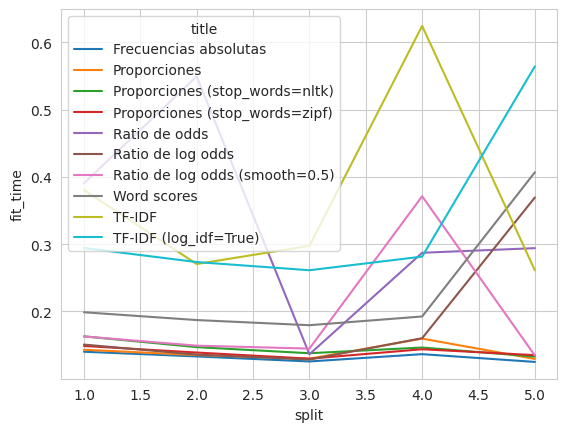

In [18]:
sns.lineplot(
    cv_results_to_compare[["title", "fit_time", "split"]],
    y="fit_time", x="split",
    hue="title"
)

In [19]:
FEATURES_PLOTS = os.path.join(VISUALIZATIONS_PATH, "features")
os.makedirs(FEATURES_PLOTS, exist_ok=True)

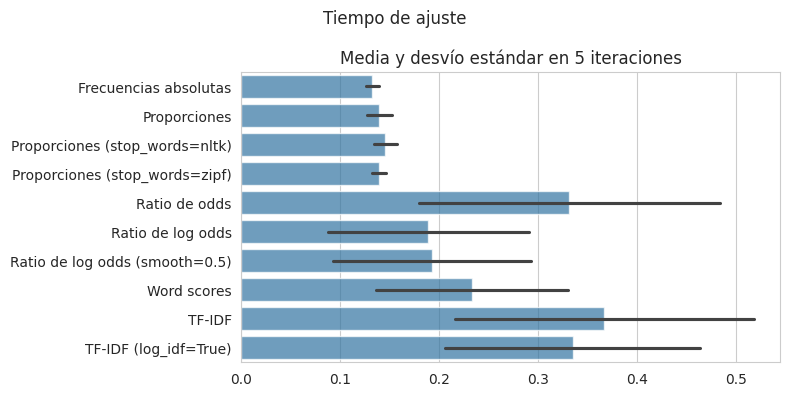

In [20]:
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(
    cv_results_to_compare[["title", "fit_time", "split"]],
    y="title", x="fit_time",
    estimator="mean", errorbar="sd", ax=ax,
    alpha=.7
)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Media y desvío estándar en 5 iteraciones")
fig.suptitle("Tiempo de ajuste")
plt.tight_layout()
plt.savefig(
        os.path.join(FEATURES_PLOTS, "fit_time.png")
    )

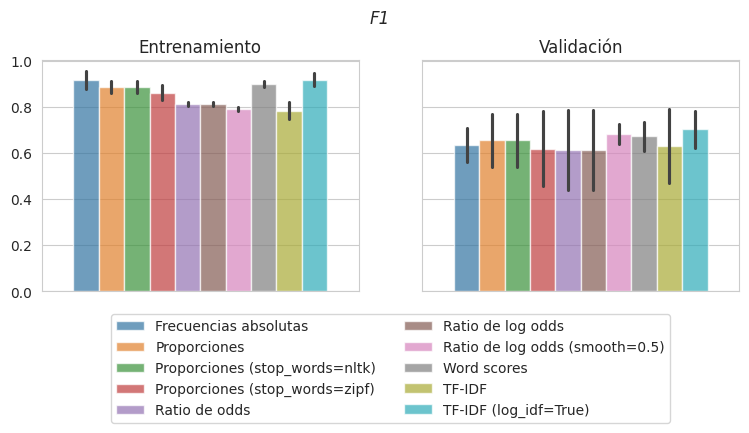

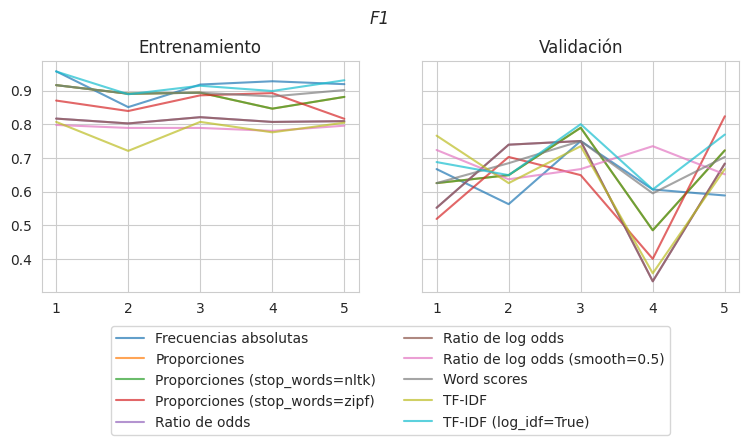

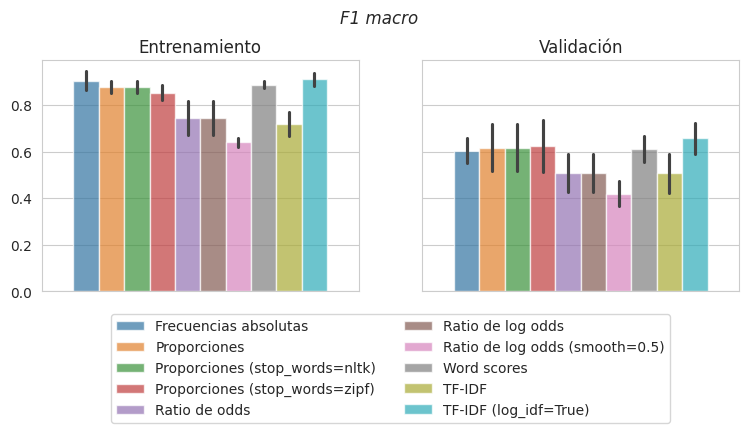

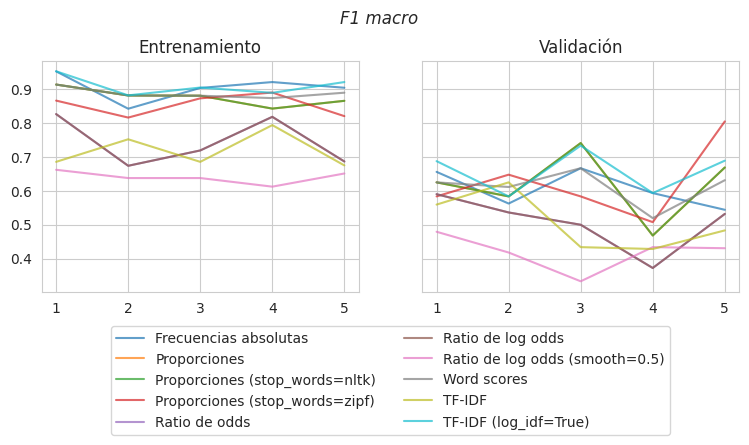

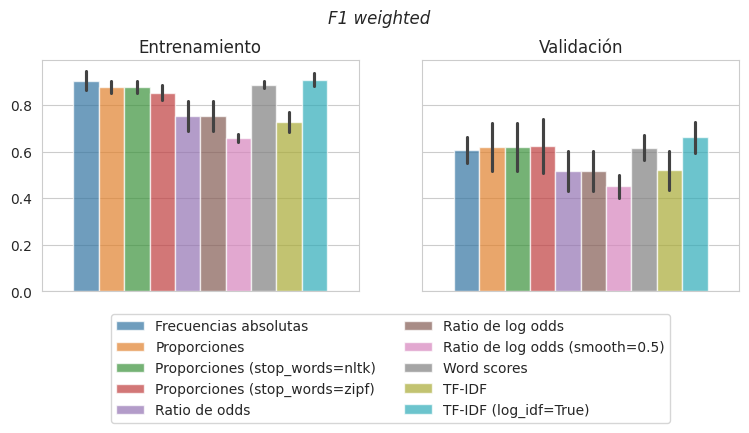

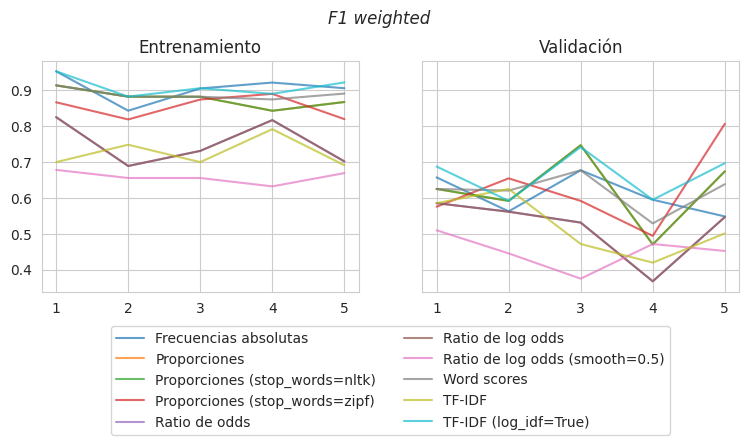

In [25]:
train_scores_cols = cv_results_to_compare.filter(like="train_f1").columns.sort_values().to_list()
test_scores_cols = cv_results_to_compare.filter(like="test_f1").columns.sort_values().to_list()

for i in range(len(train_scores_cols)):
    # mean and sd
    metric = re.sub("train_","",train_scores_cols[i])
    title = metric.replace("_", " ").capitalize()
    fig, axs = plt.subplots(1,2, figsize=(9,3), sharey=True)
    sns.barplot(
        cv_results_to_compare[["title", train_scores_cols[i], "split"]],
        hue="title", y=train_scores_cols[i], legend=False,
        estimator="mean", errorbar="sd", ax=axs[0], alpha=.7
    )
    sns.barplot(
        cv_results_to_compare[["title", test_scores_cols[i], "split"]],
        hue="title", y=test_scores_cols[i],
        estimator="mean", errorbar="sd", ax=axs[1], alpha=.7
    )
    axs[0].set_ylabel("")
    axs[0].set_title("Entrenamiento")
    axs[1].set_title("Validación")
    suptitle = fig.suptitle(f"{title}", y=1.05, style="italic")
    lgd = plt.legend(loc="lower center", bbox_to_anchor=(-0.1, -0.6), ncol=2)
    plt.savefig(
        os.path.join(FEATURES_PLOTS, f"{metric}_mean_sd.png"),
        bbox_extra_artists=[lgd,suptitle], bbox_inches='tight'
    )
    # deaggregated
    fig, bxs = plt.subplots(1,2, figsize=(9,3), sharey=True)
    sns.lineplot(
        cv_results_to_compare[["title", train_scores_cols[i], "split"]],
        y=train_scores_cols[i], x="split",
        hue="title", ax=bxs[0], legend=False, alpha=.7
    )
    sns.lineplot(
        cv_results_to_compare[["title", test_scores_cols[i], "split"]],
        y=test_scores_cols[i], x="split", alpha=.7,
        hue="title", ax=bxs[1]
    )
    bxs[0].set_ylabel("")
    bxs[0].set_xlabel("")
    bxs[1].set_xlabel("")
    bxs[0].set_title("Entrenamiento")
    bxs[1].set_title("Validación")
    suptitle = fig.suptitle(f"{title}", y=1.05, style="italic")
    lgd = plt.legend(loc="lower center", bbox_to_anchor=(-0.1, -0.65), ncol=2)
    plt.savefig(
        os.path.join(FEATURES_PLOTS, f"{metric}_by_split.png"),
        bbox_extra_artists=[lgd,suptitle], bbox_inches='tight'
    )

In [22]:
import colorsys
import matplotlib.colors as mcolors

def select_color(x: int, saturation: float):
    _rgb = sns.color_palette()[x]
    hls = colorsys.rgb_to_hls(*_rgb)
    return hls

sns.color_palette()[1]

(1.0, 0.4980392156862745, 0.054901960784313725)

In [23]:
N = (
    cv_results_to_compare
    .drop(columns=["vectorizer", "kwargs", "kwargs_", "split"])
    .groupby("title")
    [["test_accuracy", "test_precision", "test_recall", "test_f1", "test_f1_weighted", "test_f1_macro"]]
    .agg(["mean"])
    .applymap(lambda x: round(x,3))
)
N.columns = list(map(lambda x: x.strip("test_"),N.columns.droplevel(1)))
N.rename_axis(index="vectorizador", inplace=True)
N.style.highlight_max(color="blue")


,accuracy,precision,recall,f1,f1_weighted,f1_macro
vectorizador,,,,,,
Frecuencias absolutas,0.610000,0.663000,0.618000,0.635000,0.608000,0.605000
Proporciones,0.623000,0.663000,0.653000,0.654000,0.622000,0.617000
Proporciones (stop_words=nltk),0.623000,0.663000,0.653000,0.654000,0.622000,0.617000
Proporciones (stop_words=zipf),0.636000,0.726000,0.576000,0.619000,0.624000,0.625000
Ratio de log odds,0.560000,0.587000,0.698000,0.611000,0.518000,0.506000
Ratio de log odds (smooth=0.5),0.541000,0.555000,0.887000,0.682000,0.451000,0.419000
Ratio de odds,0.560000,0.587000,0.698000,0.611000,0.518000,0.506000
TF-IDF,0.572000,0.595000,0.731000,0.630000,0.521000,0.506000
TF-IDF (log_idf=True),0.667000,0.699000,0.721000,0.702000,0.663000,0.657000
